# Milestone 1

## Setup and Imports

In [1]:
!pip3 install lxml
!pip3 install html5lib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from bs4 import BeautifulSoup

## Scraping

While the USDA data we'll be using is actually downloadable in many convenient formats we'll access it via webscraping for tutorial purposes. We'll be grabbing the data from [this table](https://quickstats.nass.usda.gov/results/EA7182BD-87D0-3E47-A9C0-A9D9260F3794), which is just the results of searching for sales of by crop by state in all census years. However, while we won't be using the download data feature of the USDA website we *will* be accessing a slightly [easier to parse version of their site](https://quickstats.nass.usda.gov/data/printable/0A90D9FE-6F14-3E82-83C7-BC9FB48E126A), which is just the same table but formated for printing, so the html is a bit cleaner. Let's start by requesting the page and making some beautiful soup.

In [3]:
# we have to trick the usda, which I hope isn't a felony
r = requests.get("https://quickstats.nass.usda.gov/data/printable/0A90D9FE-6F14-3E82-83C7-BC9FB48E126A",
                headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:101.0) Gecko/20100101 Firefox/101.0'})
assert r.status_code == 200

In [4]:
soup = BeautifulSoup(r.text, "html.parser")

And thank Uncle Sam this reads into pandas nice and cleanly.

In [5]:
ag_df = pd.read_html(str(soup.find("table")))[0]
ag_df

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,CENSUS,2017,YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (111),1180774000,2.8
1,CENSUS,2017,YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (1111),315393000,5.6
2,CENSUS,2017,YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (11111),62429000,8.6
3,CENSUS,2017,YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (11112),10000,(H)
4,CENSUS,2017,YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (11113),7000,55.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,CENSUS,2002,YEAR,NaN,STATE,WYOMING,56,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (1125),3210000,NaN
9896,CENSUS,2002,YEAR,NaN,STATE,WYOMING,56,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (1129),21966000,NaN
9897,CENSUS,2002,YEAR,NaN,STATE,WYOMING,56,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (11291),2255000,NaN
9898,CENSUS,2002,YEAR,NaN,STATE,WYOMING,56,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (11292),10392000,NaN


## Cleaning

There are a few steps to cleaning here, let's start by dropping all columsn we don't need, all of which are either single valued (e.d. Period), empty (e.g. Week Ending), or essential duplicates of other columns (e.g. State ANSI). Note that this step doesn't actually remove any information from the data set - we're strictly getting rid of duplicate or empty data. Also, on a programming level, notice that we can just do this by simply grabbing the handful of columns we *do* want. This leaves us with the following data:

* Year: The year of the census this data is from.
* State: The state this data is from.
* Domain Category: The (badly titled - we'll fix that soon) NAICS classification of the crop this data represents.
* Value: The value of the crop from the state in a particular year.

In [6]:
ag_df = ag_df.loc[:, ['Year', 'State', 'Domain Category', 'Value']]
ag_df

,Year,State,Domain Category,Value
0,2017,ALABAMA,NAICS CLASSIFICATION: (111),1180774000
1,2017,ALABAMA,NAICS CLASSIFICATION: (1111),315393000
2,2017,ALABAMA,NAICS CLASSIFICATION: (11111),62429000
3,2017,ALABAMA,NAICS CLASSIFICATION: (11112),10000
4,2017,ALABAMA,NAICS CLASSIFICATION: (11113),7000
...,...,...,...,...
9895,2002,WYOMING,NAICS CLASSIFICATION: (1125),3210000
9896,2002,WYOMING,NAICS CLASSIFICATION: (1129),21966000
9897,2002,WYOMING,NAICS CLASSIFICATION: (11291),2255000
9898,2002,WYOMING,NAICS CLASSIFICATION: (11292),10392000


This is looking a lot more manageable, but now we have some data type/inconsistent value problems.First is that ugly Domain Category column - not only is it badly named, it's also in a pretty ugly format. Let's create a new column and extraxt the actual classification value from each row, then drop the original column.

In [7]:
ag_df.loc[:, 'NAICS'] = [re.findall(r"\d+", s)[0] for s in ag_df['Domain Category']]
ag_df.drop(['Domain Category'], axis=1, inplace=True)
ag_df

,Year,State,Value,NAICS
1813,2017,OREGON,3277708000,111
1814,2017,OREGON,228861000,1111
1815,2017,OREGON,(D),11112
1816,2017,OREGON,(D),11113
1817,2017,OREGON,183092000,11114
...,...,...,...,...
9269,2002,OREGON,40119000,1129
9270,2002,OREGON,2853000,11291
9271,2002,OREGON,17031000,11292
9272,2002,OREGON,9247000,11293


/tmp/ipykernel_82677/623878264.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ag_df[ag_df['State'] == 'OREGON'][ag_df['Year'] == 2017]


,Year,State,Value,NAICS
1813,2017,OREGON,3277708000,111
1814,2017,OREGON,228861000,1111
1815,2017,OREGON,(D),11112
1816,2017,OREGON,(D),11113
1817,2017,OREGON,183092000,11114
1818,2017,OREGON,20716000,11115
1819,2017,OREGON,24909000,11119
1820,2017,OREGON,524590000,1112
1821,2017,OREGON,142863000,111211
1822,2017,OREGON,381727000,111219


So, we now have the data we actually care about for this column, but it's still not perfect - what even is an NAICS class? Well NAICS is simply a set of codes that the government uses to denote specific industries. Anything that starts with 11 is Agriculture, 111 is crops (vegetable, fruits, ect), 112 livestock, etc. This goes on to very high level of specificity, for instance 111110 is Soybeans, and 111120 is non-soybean oilbeans. The real question of this data cleaning stage is how to handle NAICS - we could compress everything to fairly high level categories (say 4 digits, this would be on the level of Grain, Vegetable, Hog, Cattle, etc) and drop all other data - this has the advantage of reducing the size of our dataset and being easy to translate NAICS codes. We could also translate each individual NAICS code to get a more granular break down. Eventually we'll want to do the later, but handling each code is a lot of work - for the purposes of exploration let's just translate the four digit codes and create a condensed dataframe.

In [8]:
cond_ag_df = ag_df.loc[[len(code) == 4 for code in ag_df['NAICS']]].copy()
cond_ag_df.reset_index(inplace=True)

Now we can create a new column for the meanings of the codes, which for now we'll convert manually with a dictionary.

In [9]:
naics_dict = {
    '1111' : 'Oilseed and Grain',
    '1112' : 'Vegetable and Melon',
    '1113' : 'Fruit and Tree Nut',
    '1114' : 'Greenhouse, Nursery, and Floriculture',
    '1119' : 'Other Crops',
    '1121' : 'Cattle',
    '1122' : 'Hog',
    '1123' : 'Poultry',
    '1124' : 'Sheep and Goat',
    '1125' : 'Aquaculture',
    '1129' : 'Other Animals'
}

cond_ag_df.loc[:, 'Category'] = [naics_dict[code] for code in cond_ag_df['NAICS']]
print(cond_ag_df.dtypes)
cond_ag_df

index        int64
Year         int64
State       object
Value       object
NAICS       object
Category    object
dtype: object


,index,Year,State,Value,NAICS,Category
0,1,2017,ALABAMA,315393000,1111,Oilseed and Grain
1,8,2017,ALABAMA,53633000,1112,Vegetable and Melon
2,11,2017,ALABAMA,16156000,1113,Fruit and Tree Nut
3,22,2017,ALABAMA,295784000,1114,"Greenhouse, Nursery, and Floriculture"
4,27,2017,ALABAMA,499808000,1119,Other Crops
...,...,...,...,...,...,...
2295,9888,2002,WYOMING,22536000,1122,Hog
2296,9889,2002,WYOMING,546000,1123,Poultry
2297,9892,2002,WYOMING,25076000,1124,Sheep and Goat
2298,9895,2002,WYOMING,3210000,1125,Aquaculture


With this we're almost done, just have to deal with the typing on the Value column - currently that's strings because of some "(D)" values. In the dataset that means that the USDA isn't publishing the data because it would compromise the details of an operation - usually because there's only one, say, citrus orchard in Alaska. We got rid of most of those when we compressed the dataset into just the major categories, but there are still a few. We'll replace those with NaN - this might not be the best approach if we wanted to do real predictive work, but for exploration purposes it's fine.

In [10]:
cond_ag_df.loc[:, 'Value'] = [float(val) if val != '(D)' else np.nan for val in cond_ag_df['Value']]
cond_ag_df

,index,Year,State,Value,NAICS,Category
0,1,2017,ALABAMA,315393000.0,1111,Oilseed and Grain
1,8,2017,ALABAMA,53633000.0,1112,Vegetable and Melon
2,11,2017,ALABAMA,16156000.0,1113,Fruit and Tree Nut
3,22,2017,ALABAMA,295784000.0,1114,"Greenhouse, Nursery, and Floriculture"
4,27,2017,ALABAMA,499808000.0,1119,Other Crops
...,...,...,...,...,...,...
2295,9888,2002,WYOMING,22536000.0,1122,Hog
2296,9889,2002,WYOMING,546000.0,1123,Poultry
2297,9892,2002,WYOMING,25076000.0,1124,Sheep and Goat
2298,9895,2002,WYOMING,3210000.0,1125,Aquaculture


## Exploratory Analysis

So what we have is essentially each's states total output of different agricultural industries in four different years. There's some obvious questions to ask here, starting with the top industry for each state, and vice versa. Let's start by sorting the entire frame by the value, this gives us a nice absolute ordering on all data which we can use to make our job much simpler.

In [11]:
sorted_df = cond_ag_df.sort_values(by='Value', ascending=False)
sorted_df

,index,Year,State,Value,NAICS,Category
50,206,2017,CALIFORNIA,19557810000.0,1113,Fruit and Tree Nut
650,2724,2012,CALIFORNIA,17417879000.0,1113,Fruit and Tree Nut
768,3223,2012,IOWA,16845993000.0,1111,Oilseed and Grain
1109,4667,2012,TEXAS,14720166000.0,1121,Cattle
509,2144,2017,TEXAS,14454707000.0,1121,Cattle
...,...,...,...,...,...,...
2263,9749,2002,WASHINGTON,NaN,1123,Poultry
2264,9755,2002,WASHINGTON,NaN,1124,Sheep and Goat
2289,9861,2002,WYOMING,NaN,1111,Oilseed and Grain
2290,9867,2002,WYOMING,NaN,1112,Vegetable and Melon


Now we can just pull the first matching entry for anything we want to know, let's start with the top industry in every state for every year in our dataset.

In [12]:
for state in sorted_df['State'].unique():
    print(state + ":")
    state_df = sorted_df[sorted_df['State'] == state]
    for year in sorted_df['Year'].unique():
        print("    " + str(year) + ":" + state_df[state_df['Year'] == year].iloc[0]['Category'])

CALIFORNIA:
    2017:Fruit and Tree Nut
    2012:Fruit and Tree Nut
    2007:Fruit and Tree Nut
    2002:Fruit and Tree Nut
IOWA:
    2017:Oilseed and Grain
    2012:Oilseed and Grain
    2007:Oilseed and Grain
    2002:Oilseed and Grain
TEXAS:
    2017:Cattle
    2012:Cattle
    2007:Cattle
    2002:Cattle
ILLINOIS:
    2017:Oilseed and Grain
    2012:Oilseed and Grain
    2007:Oilseed and Grain
    2002:Oilseed and Grain
MINNESOTA:
    2017:Oilseed and Grain
    2012:Oilseed and Grain
    2007:Oilseed and Grain
    2002:Oilseed and Grain
KANSAS:
    2017:Cattle
    2012:Cattle
    2007:Cattle
    2002:Cattle
NEBRASKA:
    2017:Cattle
    2012:Oilseed and Grain
    2007:Cattle
    2002:Cattle
NORTH DAKOTA:
    2017:Oilseed and Grain
    2012:Oilseed and Grain
    2007:Oilseed and Grain
    2002:Oilseed and Grain
WISCONSIN:
    2017:Cattle
    2012:Cattle
    2007:Cattle
    2002:Cattle
INDIANA:
    2017:Oilseed and Grain
    2012:Oilseed and Grain
    2007:Oilseed and Grain
    2002:O

Seems like agricultural specialities in states have stayed more or less the same between 2002-2017, with a few changes here and there. We can also look at the opposite - which state was the most important in each category each year?

In [13]:
for cat in sorted_df['Category'].unique():
    print(cat + ":")
    cat_df = sorted_df[sorted_df['Category'] == cat]
    for year in sorted_df['Year'].unique():
        print("    " + str(year) + ":" + cat_df[cat_df['Year'] == year].iloc[0]['State'])

Fruit and Tree Nut:
    2017:CALIFORNIA
    2012:CALIFORNIA
    2007:CALIFORNIA
    2002:CALIFORNIA
Oilseed and Grain:
    2017:ILLINOIS
    2012:IOWA
    2007:ILLINOIS
    2002:IOWA
Cattle:
    2017:TEXAS
    2012:TEXAS
    2007:TEXAS
    2002:TEXAS
Hog:
    2017:IOWA
    2012:IOWA
    2007:IOWA
    2002:IOWA
Vegetable and Melon:
    2017:CALIFORNIA
    2012:CALIFORNIA
    2007:CALIFORNIA
    2002:CALIFORNIA
Poultry:
    2017:GEORGIA
    2012:NORTH CAROLINA
    2007:GEORGIA
    2002:GEORGIA
Greenhouse, Nursery, and Floriculture:
    2017:CALIFORNIA
    2012:CALIFORNIA
    2007:CALIFORNIA
    2002:CALIFORNIA
Other Crops:
    2017:TEXAS
    2012:CALIFORNIA
    2007:TEXAS
    2002:CALIFORNIA
Other Animals:
    2017:KENTUCKY
    2012:IOWA
    2007:KENTUCKY
    2002:KENTUCKY
Aquaculture:
    2017:KENTUCKY
    2012:IOWA
    2007:MISSISSIPPI
    2002:WASHINGTON
Sheep and Goat:
    2017:COLORADO
    2012:TEXAS
    2007:TEXAS
    2002:TEXAS


We can do pretty much anything in this vein we can think of, but let's check out some more interesting stats. Lets look at the mean, median, and the ratio of the two - to get a basic idea of the skew.

In [14]:
clean_mean = lambda x : f"{x.mean():.2f}"
clean_median = lambda x : f"{x.median():.2f}"
ratio = lambda x : f"{x.median() / x.mean() : .4f}"
cond_ag_df.groupby(['Year', 'Category'])['Value'].agg([['mean', clean_mean], ['median', clean_median], ["median mean ratio", ratio]])

mean         median  \
Year Category                                                              
2002 Aquaculture                              23957234.04     5767000.00   
     Cattle                                 1307768840.00   668601500.00   
     Fruit and Tree Nut                      287000829.79    18312000.00   
     Greenhouse, Nursery, and Floriculture   301311840.00   162686000.00   
     Hog                                     261917170.21    40964000.00   
     Oilseed and Grain                       798067510.64   273285000.00   
     Other Animals                            65947340.43    34303000.00   
     Other Crops                             290961980.00   171126500.00   
     Poultry                                 515921744.68   230197000.00   
     Sheep and Goat                            9138250.00     3504000.00   
     Vegetable and Melon                     275823659.57    66040000.00   
2007 Aquaculture                              29918276.60     9304000.00   
     Cattle                                 1850768620.00   860195500.00   
     Fruit and Tree Nut                      390132468.09    25428000.00   
     Greenhouse, Nursery, and Floriculture   339342440.00   150211000.00   
     Hog                                     393124869.57    53563000.00   
     Oilseed and Grain                      1656616644.44   522969000.00   
     Other Animals                           102361808.51    45468000.00   
     Other Crops                             370402695.65   199487000.00   
     Poultry                                 803078170.21   310758000.00   
     Sheep and Goat                           11695304.35     5198500.00   
     Vegetable and Melon                     299506400.00    69820500.00   
2012 Aquaculture                              79523560.44    39993000.00   
     Cattle                                 2243656160.00  1097604000.00   
     Fruit and Tree Nut                      541766255.32    24744000.00   
     Greenhouse, Nursery, and Floriculture   294727480.00   128520000.00   
     Hog                                     512780931.82    50669500.00   
     Oilseed and Grain                      2554253580.00   971830500.00   
     Other Animals                            99572837.21    57858000.00   
     Other Crops                             524675276.60   331296000.00   
     Poultry                                1010080767.44   488726000.00   
     Sheep and Goat                           16669886.36     7030000.00   
     Vegetable and Melon                     368286911.11    95482000.00   
2017 Aquaculture                              82663515.46    45922000.00   
     Cattle                                 2296184440.00  1014619500.00   
     Fruit and Tree Nut                      602388468.09    26207000.00   
     Greenhouse, Nursery, and Floriculture   329923040.00   141422500.00   
     Hog                                     576664829.79    65682000.00   
     Oilseed and Grain                      2170485659.57   682045000.00   
     Other Animals                            94492021.28    56063000.00   
     Other Crops                             471760895.83   296269500.00   
     Poultry                                1062731595.74   412136000.00   
     Sheep and Goat                           18698000.00     8942000.00   
     Vegetable and Melon                     410909375.00   104908000.00   

                                           median mean ratio  
Year Category                                                 
2002 Aquaculture                                      0.2407  
     Cattle                                           0.5113  
     Fruit and Tree Nut                               0.0638  
     Greenhouse, Nursery, and Floriculture            0.5399  
     Hog                                              0.1564  
     Oilseed and Grain                                0.3424  
     Other Animals                                  

Mean and median here are self explanatory, and honestly not that interesting - but we can see a general pattern that mean tends to be much higher than median, a sign of left tailed data. This makes sense, as states tend to specialize in particular types of agriculture for climate, geographic, expertise, and cultural reasons (or at least we would tend to believe). We can quantify this a little more by observing that the median/mean ratio doesn't go much higher than .6, and that rarely. In some cases we don't realy get over a tenth - hogs and fruits are clearly incredibly skewed, and our earlier look at the most valuable states for each industry show us that the likely culprits are Iowa (hogs) and California (Fruits).

Let's try and verify those hypothesis visually with some pie charts across each industry category. We have to choose how to handle the four years in the dataset here, and I'm just going to drop everything but 2017 for these charts, just to keep things simpler, get a sense of how unbalanced each category is.

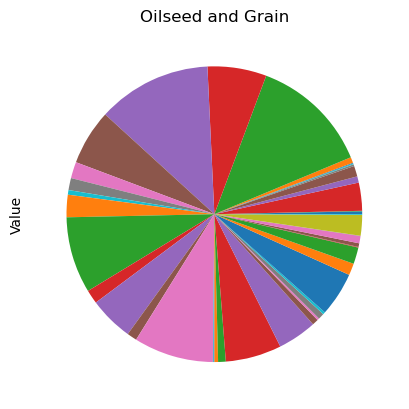

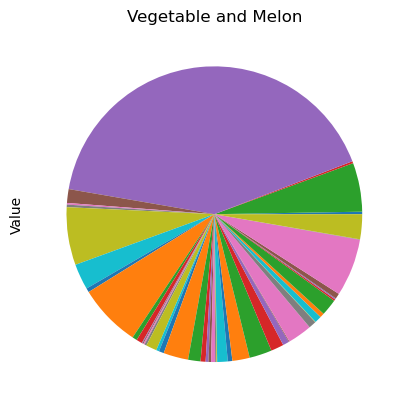

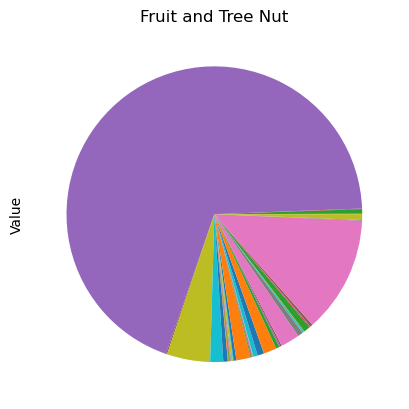

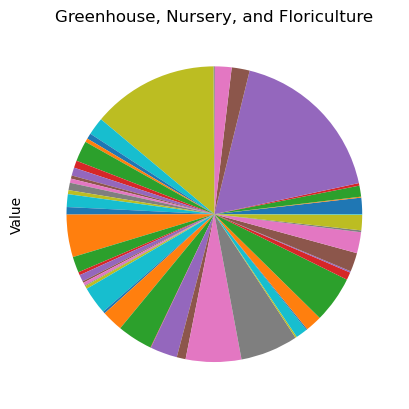

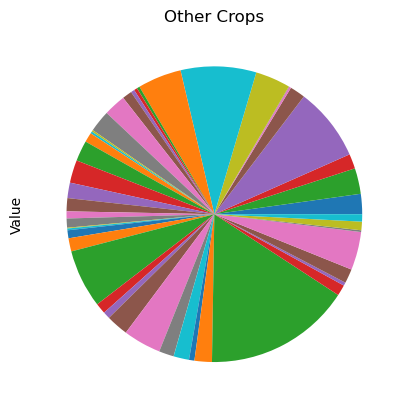

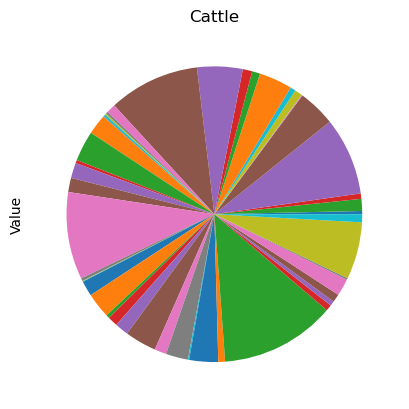

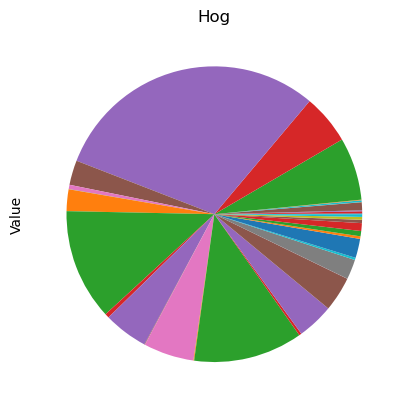

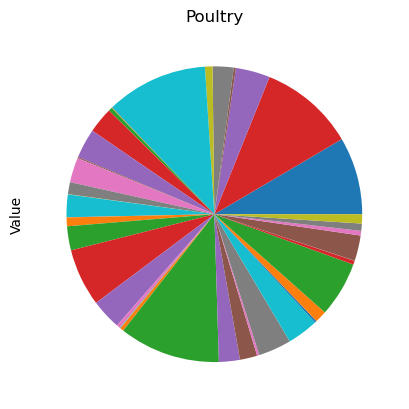

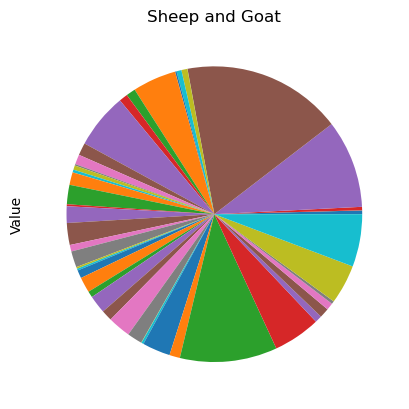

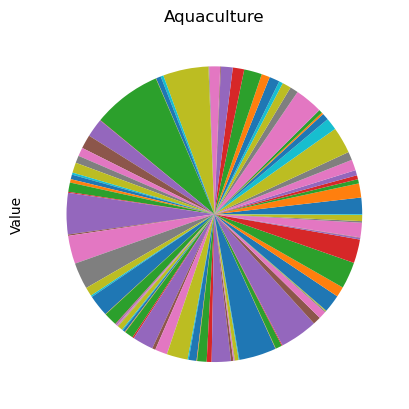

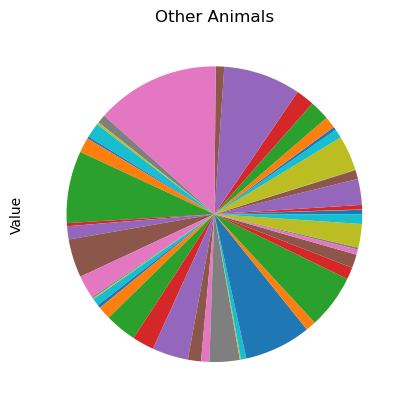

In [15]:
recent_df = cond_ag_df[cond_ag_df['Year'] == 2017].loc[:, ['Category', 'State', 'Value']]
for cat in recent_df['Category'].unique():
    recent_df[recent_df['Category'] == cat].set_index('State').plot.pie(y='Value', legend=False, labels=None, title=cat)

As we can see most industries have some large players (no labels yet due to large index sets, working on it), usually Texas and California, but some are absolutely dominated by a single state, especially Vegetables, Fruits, and Hogs. As we can see, with a fairly basic dataset we can already begin to the see the outline of the ways that different agricultural industries are practiced across the United States, 